# Problem Introduction

Our task is to build a model, which is suitable for recommending books based on user reviews from open BX dataset.

TL;DR If there are users with similar taste in books, we want to recommend them the respective part of symmetric difference of books they liked

So lets tackle this problem using `numpy`, `pandas` and `sklearn`

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

# Exploratory Data Analysis

In [2]:
# input is encoded in latin-1 and there are come corrupted values
# as there is not many of those values, I decided to just skip them

books_df = pd.read_csv( "data/BX-Books.csv", encoding="latin-1", sep=";", on_bad_lines="skip", low_memory=False )
ratings_df = pd.read_csv( "data/BX-Book-Ratings.csv", encoding="latin-1", sep=";", on_bad_lines="skip" )
users_df = pd.read_csv( "data/BX-Users.csv", encoding="latin-1", sep=";", on_bad_lines="skip" )

In [3]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


As can be seen, there are some redundant columns which we do not want to consider when deciding what book to recommend, so lets get rid of them

In [4]:
books_df.drop( columns=[ "Image-URL-S", "Image-URL-M", "Image-URL-L", "Publisher", "Year-Of-Publication", "Book-Author" ], inplace=True )
books_df.columns = [ "ISBN", "title" ] #, "author" ]

In [5]:
users_df.columns = [ "user-id", "location", "age" ]

In [6]:
ratings_df.columns = [ "user-id", "ISBN", "rating" ]

<AxesSubplot:>

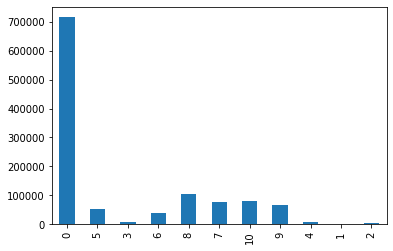

In [7]:
ratings_df[ "rating" ].value_counts( sort=False ).plot( kind="bar" )

<AxesSubplot:>

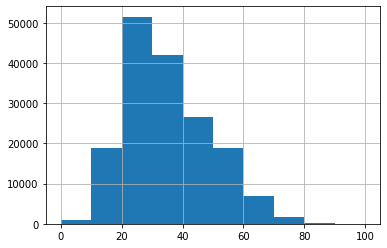

In [8]:
users_df[ "age" ].hist( bins=list( range( 0, 110, 10 ) ) )

<AxesSubplot:ylabel='None'>

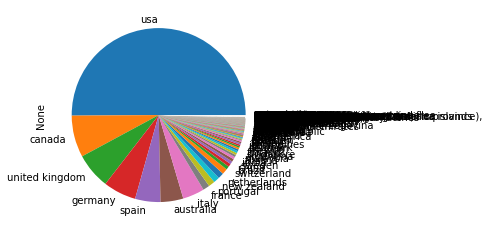

In [9]:
locations = pd.Series( map( lambda l: l.split( ", " )[ -1], users_df[ "location" ].dropna() ) )
locations.value_counts().plot( kind="pie" )

# Data Preparation

We _do not_ want to include reviews from users, who have too less, or too much reviews. Similarily, we do not want to recommend books, for which we do not have solid foundation of reviews from different users.

In [10]:
ratings_df[ "user-id" ].unique().shape

(105283,)

As can be seen, we have unique 105283 unique users who have left a review. Now we want to find some threshold when the user becomes relevant based on how much reviews he have left.

In [11]:
user_rating_counts = ratings_df[ "user-id" ].value_counts()
print( f"0.25 quantile: {user_rating_counts.quantile( q=0.25 )}" )
print( f"0.5 quantile: {user_rating_counts.quantile( q=0.5 )}" )
print( f"0.75 quantile: {user_rating_counts.quantile( q=0.75 )}")

0.25 quantile: 1.0
0.5 quantile: 1.0
0.75 quantile: 4.0


Observation is, that 75% or our users have left less than 5 reviews. This is kinda sad, but not that surprising - data are scraped from amazon, there are probably not that much bookworms who buy their precious books from Amazon :)

Lets say that we consider person a relevant reviewer if he has more than 50 reviews. The large values also seems suspicious, I would say they are caused by bots, therefore we gonna drop them as well.

In [12]:
user_reviews = ratings_df[ "user-id" ].value_counts()
ratings_df = ratings_df[ ratings_df[ "user-id" ].isin( user_reviews[ ( user_reviews >= 50 ) & ( user_reviews <= 500 )].index ) ]

In [13]:
books_with_ratings_df = ratings_df.merge( books_df, on="ISBN" )
books_with_ratings_df.head()

,user-id,ISBN,rating,title
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels)
1,5483,0446364193,0,Along Came a Spider (Alex Cross Novels)
2,8362,0446364193,0,Along Came a Spider (Alex Cross Novels)
3,9177,0446364193,7,Along Came a Spider (Alex Cross Novels)
4,11400,0446364193,0,Along Came a Spider (Alex Cross Novels)


<AxesSubplot:>

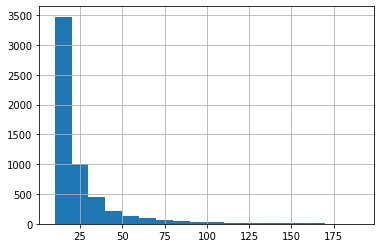

In [14]:
books_with_ratings_df = books_with_ratings_df.dropna(axis = 0, subset = ['title'])

total_book_rating_counts_df = ( books_with_ratings_df.groupby( by=[ "ISBN" ] )[ "rating" ].count().reset_index().rename( columns={ "rating": "rating-count" } )[ [ "ISBN", "rating-count" ] ] )

total_book_rating_counts_df[ "rating-count" ].hist( bins=list( range( 10, 200, 10 ) ) )

We do not want to include books, for which we do not have a solid foundation of reviews

In [15]:
books_with_ratings_df = books_with_ratings_df.merge( total_book_rating_counts_df, how="inner" )
books_with_ratings_df = books_with_ratings_df[ books_with_ratings_df[ "rating-count" ] >= 25 ]

Only thing left, is to look closely at the users. At the moment, we filtered out those with too much or too little reviews. However, demographic is also very important marker, so lets use that to possibly improve the dataset.

<AxesSubplot:ylabel='None'>

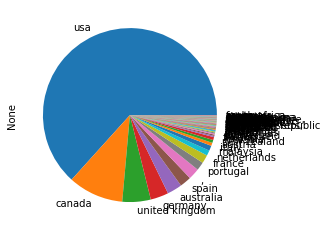

In [16]:
relevant_user_ids = books_with_ratings_df[ "user-id" ].unique()
relevant_users = users_df[ users_df[ "user-id" ].isin( relevant_user_ids ) ]
pd.Series( map( lambda l: l.split( ", " )[ -1 ], relevant_users[ "location" ] ) ).value_counts().plot( kind="pie" )

As can be seen, in our filtered dataset is now almost 75% ( ~50% before ) of users from US or Canada, and since those are two quite simmilar countries, we are going to merge them together

In [17]:
user_rating_df = books_with_ratings_df.merge( users_df, how="inner" )
usa_user_rating_df = user_rating_df[ user_rating_df[ "location" ].str.contains( "usa|canada" ) ]
usa_user_rating_df.head()
usa_user_rating_df=usa_user_rating_df.drop( "age", axis=1 )

# drop duplicate reviews, if there are some
usa_user_rating_df = usa_user_rating_df.drop_duplicates( [ "user-id", "ISBN" ] )

In [18]:
model_df = usa_user_rating_df.pivot_table( columns="user-id", index="title", values="rating" )
model_df.fillna( 0, inplace=True )

Now, we have dataframe which we can feed to our model. First idea I came up with was to use KNN, and I did not think of anything better since, as I am trying to build rather MVP rather than full blown recommendation engine 

In [19]:
def print_suggestions( title: str, model ):
    row = model_df.iloc[ model_df.index == title ]
    if row.shape[ 0 ] == 0:
        print( f"Sorry, we do not have title '{ title }' in our database" )
        return
    
    _, suggestions = model.kneighbors( row.values.reshape(1, -1) )
    for suggestion in suggestions[ 0 ]:
        print( model_df.index[ suggestion ] )
    

# Model

In [20]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors( algorithm="brute" )
model.fit( model_df )

NearestNeighbors(algorithm='brute')

In [21]:
print_suggestions( "1984", model )

print()

print_suggestions( "How to build a book recommendation engine", model )

print()

print_suggestions( "Harry Potter and the Chamber of Secrets (Book 2)", model )

print()

print_suggestions( "The Bad Place", model )

1984
Emma (Penguin Popular Classics)
Cold Fire
Blackberry Wine
Notes From a Small Planet

Sorry, we do not have title 'How to build a book recommendation engine' in our database

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Sorcerer's Stone (Book 1)
Matilda

The Bad Place
Cold Fire
Notes From a Small Planet
Angelas Ashes
Jemima J


# Future paths

I found [this](https://towardsdatascience.com/building-a-content-based-book-recommendation-engine-9fd4d57a4da) article on simmilar problem. I like the approach the author used, scraping the content and doing some NLP is a great way to make more qualified decision when doing recommendations, as we do not need the user review and worry about the outliers

Even though I dropped the images at the beginning, it would be nice to display book covers alongside the book titles, as we as humans are very visual

Currently, the model predicts something only if the two conditions are met - title is in the database and it is in the exact same format is it is sotred in the dataframe. One of the solutions is to match on ISBN (really inconvenient for the user) or to use some abstract layer, which computes for example hamming distance between possible matching titles or some other layer over the dataframe itself.

Add evaluating function for the model - I unfortunatelly was not able to come with anything I was able to make working properly, but this is a must have

Remember information about users - it is _hard_ to make a good recommendation judging by one book, it is however much easier to base receommendation on multiple books. Also enablig users to register themselves and being able to **grade** recommendation would enable us to iteratively improve the model


# Bonus excercise

I spinned up a **very simple** web page to demonstrate the model, to run instance locally, please follow these steps:
1. Install `flask`, the server I chose with `python -m pip install flask`
2. Run `python app.py`
3. If all goes well, you should get an local instance running at `https://localhost:5000`
4. **In order for model to work, you have to supply the exact format of title, as it is stored in dataset**

This is just _my_ incarnation of the app I coded on train, please be prepared :)

What I would like to implement, as mentioned above, is to enable users to create profiles and are the suggestions - they could also improve the dataset - either with new titles or with their reviews to other already present titles

At this point, the whole dataset is just one dataframe - this is not something we want to rely on with new titles and reviews. I would split it into more suitable parts ( for example like the three input datasets, maybe without the urls, or storing them in separate tables ). To achieve this, I would personally pick PostgreSQL, as I have good experience with it working with some python using `psycopg`.

Ideally, we would want to schedule iterations, in which the model is trained and evaluated and data are filtered - to perform them ideally when there is not much traffic, so it would not affect the performance of the whole product, but not to perform them too often if there are almost no new data

If this was just my personal project, I would also like to implement monetization, for example in terms of affiliate links to titles we have in dataset.